# Use Case 3: Associating Clinical Variables with Acetylation

For this use case we will show how to analyze the acetylation data with a clinical attribute. We will use the clinical attribute "Histologic_type", but you can apply the processes shown here to many other clinical attributes. Our goal is to identify which acetylation sites differ significantly in frequency between non-tumor, serous and endometrial cells.

# Step 1: Import Packages and Load Data

We will start by importing the data analysis tools we need, importing the cptac package, and loading the Endometrial dataset.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import math
import cptac
import cptac.utils as ut

en = cptac.Endometrial()

# Step 2: Choose Clinical Attribute and Join Dataframes

For this use case, we will use the 'Histologic_type' clinical attribute in order to find differences in acetylation sites between "endometrioid" and "serous" cancer cells. 

In [2]:
#Set desired attribute to variable 'clinical_attribute'
clinical_attribute = "Histologic_type"

Here we will join our desired clinical attribute with our acetylation dataframe using the <code>en.join_metadata_to_omics</code> method.

In [3]:
#Join attribute with acetylation dataframe
clinical_and_acetylation = en.join_metadata_to_omics(metadata_df_name="clinical", omics_df_name="acetylproteomics",
                                                     metadata_cols=clinical_attribute)
clinical_and_acetylation = en.reduce_multiindex(df=clinical_and_acetylation, flatten=True)
clinical_and_acetylation.head()

Name,Histologic_type,A2M_acetylproteomics_K1168,A2M_acetylproteomics_K1176,A2M_acetylproteomics_K135,A2M_acetylproteomics_K145,A2M_acetylproteomics_K516,A2M_acetylproteomics_K664,A2M_acetylproteomics_K682,AACS_acetylproteomics_K391,AAGAB_acetylproteomics_K290,...,ZSCAN31_acetylproteomics_K215,ZSCAN32_acetylproteomics_K659,ZW10_acetylproteomics_K634,ZYX_acetylproteomics_K24,ZYX_acetylproteomics_K25,ZYX_acetylproteomics_K265,ZYX_acetylproteomics_K272,ZYX_acetylproteomics_K279,ZYX_acetylproteomics_K533,ZZZ3_acetylproteomics_K117
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,Endometrioid,NaN,1.080,NaN,NaN,NaN,NaN,NaN,NaN,0.461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S002,Endometrioid,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,1.770,...,-0.104,-0.80300,NaN,-0.988,-0.343,-0.307,NaN,-0.0955,NaN,NaN
S003,Endometrioid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815,...,NaN,NaN,NaN,-0.459,-1.170,NaN,NaN,-0.7050,0.089,NaN
S005,Endometrioid,NaN,-0.608,NaN,NaN,-0.919,NaN,NaN,NaN,NaN,...,-0.457,-0.00175,-0.33,NaN,-0.537,NaN,NaN,-0.3700,NaN,NaN
S006,Serous,NaN,1.630,NaN,2.4,NaN,NaN,1.26,NaN,0.205,...,NaN,0.41100,NaN,NaN,-0.358,NaN,NaN,-0.9700,NaN,NaN


# Step 3: Format Dataframe to Compare Acetylproteomic Sites Between Histologic Types

In [4]:
#Show possible variations of Histologic_type
clinical_and_acetylation[clinical_attribute].unique()

array(['Endometrioid', 'Serous', nan], dtype=object)

In this step, we will make two different dataframes for "Endometrioid" and "Serous" cancer types, as well as fill the NaN columns with "Non-Tumor."

In [5]:
#Make dataframes with only endometrioid and only serous data in order to compare 
endom = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Endometrioid"]
serous = clinical_and_acetylation.loc[clinical_and_acetylation[clinical_attribute] == "Serous"]
#Here is where we set the NaN values to "Non_Tumor"
clinical_and_acetylation[[clinical_attribute]] = clinical_and_acetylation[[clinical_attribute]].fillna(
    value="Non_Tumor")

Now that we have our different dataframes, we want to make sure that the amount of data we are using for each site is significant. Since there are fewer patients with "serous" tumors than with "endometrioid," we will check to make sure that we have at least five values for each acetylation site that we are comparing that have a measurement of intensity for serous patients. We will remove every acetylation site from our dataframe that doesn't have at least five values among the serous patients.

In [6]:
#Remove every column that doesn't have at least 5 values among the serous patients
print("Total Sites: ", len(serous.columns) - 1)
sites_to_remove = []
for num in range(1, len(serous.columns)):
    serous_site = serous.columns[num]
    one_site = serous[serous_site]
    num_datapoints_ser = one_site.count()
    if num_datapoints_ser < 5:
        sites_to_remove.append(serous_site)

clinical_and_acetylation = clinical_and_acetylation.drop(sites_to_remove, axis = 1)

#Also remove non-tumor patients from our dataframe to use in comparison, as we want to compare only endometrioid and serous types
clinical_and_acetylation_comparison = clinical_and_acetylation.loc[clinical_and_acetylation['Histologic_type'] != 'Non_Tumor']

print("Removed: ", len(sites_to_remove))
print("Remaining Sites: ", len(clinical_and_acetylation_comparison.columns) - 1)
print("Adjusted p-value cutoff will be: ", .05/(len(clinical_and_acetylation_comparison.columns)-1))


Total Sites:  10862
Removed:  6926
Remaining Sites:  3936
Adjusted p-value cutoff will be:  1.2703252032520325e-05


# Step 4: Compare Endometrioid and Serous Values

We will now call the wrap_ttest method, which will loop through the data and compare endometrioid versus serous data for each acetylation site. If we find a site that is significantly different, we will add it to a dataframe, with its p-value. The default alpha used is .05, which will be adjusted to account for multiple testing using a bonferroni correction, dividing alpha by the number of comparison that will occur (the number of comparison columns).

In [7]:
#Make list of all remaining sites in dataframe to pass to wrap_ttest function
columns_to_compare = list(clinical_and_acetylation_comparison.columns)

#Remove the "Histologic_type" column (at index 0) from this list 
columns_to_compare = columns_to_compare[1:]

#Perform ttest on each column in dataframe
significant_sites_df = ut.wrap_ttest(df=clinical_and_acetylation_comparison, label_column="Histologic_type", comparison_columns=columns_to_compare)

#List significant results
significant_sites_df

,Comparison,P_Value
0,TBL1XR1_acetylproteomics_K102,2.896155e-08
1,FOXA2_acetylproteomics_K280,3.895704e-08
2,SRRT_acetylproteomics_K720,6.532244e-08
3,TOP2A_acetylproteomics_K1433,1.677067e-07
4,NCL_acetylproteomics_K398,3.077308e-07
5,MEAF6_acetylproteomics_K69,5.336611e-07
6,JADE3_acetylproteomics_K32,9.009262e-07
7,NOP2_acetylproteomics_K91,2.099527e-06
8,TOP2A_acetylproteomics_K1422,2.623814e-06
9,MCRS1_acetylproteomics_K136,3.942592e-06


# Step 5: Graph Results

Now that we have eight acetylation sites that differ significantly between endometrioid and serous intensities, we will graph a couple of them using a boxplot and a stripplot in order to visually see the difference, as well as compare with normal cells.

Ttest_indResult(statistic=5.991702127182772, pvalue=3.89570439448459e-08)


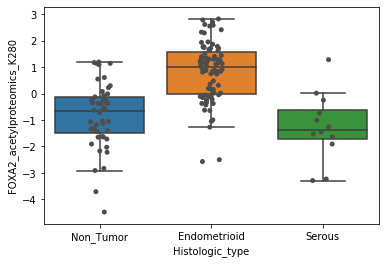

In [8]:
graphingSite = 'FOXA2_acetylproteomics_K280'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data=clinical_and_acetylation, showfliers=False, 
            order=["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data=clinical_and_acetylation, color='.3', 
              order=["Non_Tumor", "Endometrioid", "Serous"])

Ttest_indResult(statistic=-6.058405376720225, pvalue=2.8961545616585784e-08)


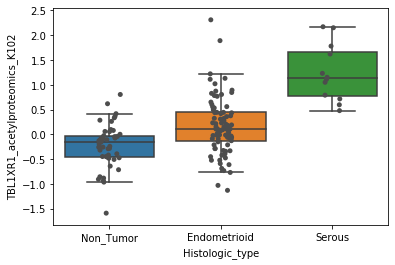

In [9]:
graphingSite = 'TBL1XR1_acetylproteomics_K102'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data=clinical_and_acetylation, showfliers = False, 
            order=["Non_Tumor", "Endometrioid", "Serous"])
sns.stripplot(x=clinical_attribute, y=graphingSite, data=clinical_and_acetylation, color='.3', 
              order=["Non_Tumor", "Endometrioid", "Serous"])